# LDA Assignment 6

### Roll no: MIT2018020

2.Face recognition using LDA 

Hints:

Create face dataset using your mobile phone for your face as well as faces of 9 other friends.Create multiple variants (at least 5) of each faces with different view angles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pathlib
from PIL import Image
from scipy.linalg import eigh
import re

In [2]:
img_paths = pathlib.Path('./imglq/train/').glob('*')
img_sorted = sorted([x for x in img_paths])

In [3]:
paths = list(map(str, img_sorted))
names_train = [re.findall(r'/([^/]+)_\d+.*$',p)[0] for p in paths]
names_train

['Aditya',
 'Aditya',
 'Aditya',
 'Aditya',
 'Ajay',
 'Ajay',
 'Ajay',
 'Ajay',
 'Arindam',
 'Arindam',
 'Arindam',
 'Arindam',
 'Mohit',
 'Mohit',
 'Mohit',
 'Mohit',
 'Priyo',
 'Priyo',
 'Priyo',
 'Priyo',
 'Sumanth',
 'Sumanth',
 'Sumanth',
 'Sumanth']

In [4]:
img = []
for im_path in img_sorted[:]:
    im = np.array(Image.open(str(im_path)).convert('L'))
    img.append(np.array(im.reshape(-1)))

In [5]:
data = np.array(img).T
mean = np.mean(data,axis = 1).reshape(-1,1)
data = data - mean

In [23]:
cov = np.cov(data.T)
lam, V = eigh(cov,eigvals=(19,23))

In [24]:
V.shape, lam.shape

((24, 5), (5,))

In [25]:
eigen_face = V.T @ data.T
eigen_face.shape

(5, 5625)

In [26]:
signature = (eigen_face @ data)

In [27]:
signature.shape

(5, 24)

## LDA 

In [28]:
mean_proj = np.mean(signature,axis = 1)
mean_proj

array([-1.55220429e-10, -5.04466395e-10,  4.65661287e-10, -6.20881716e-10,
       -4.34617201e-09])

In [29]:
def find_mean_class(Signature):
    mean_class = []
    for i in range(6):
        mean_class.append(Signature[:,4*(i-1):4*i-1].mean(axis=1))
    return np.array(mean_class)
mean_class = find_mean_class(signature)
mean_class.shape

(6, 5)

In [30]:
def find_Scatter_within_class(Signature):
    Scatter_within_class = np.zeros((Signature.shape[0], Signature.shape[0]))
    
    for i in range(6):
        Scatter_within_class = Scatter_within_class + Signature[:,4*(i-1):4*i-1] @ Signature[:,4*(i-1):4*i-1].T
    return Scatter_within_class
Scatter_within_class = find_Scatter_within_class(signature)

In [31]:
Scatter_within_class.shape

(5, 5)

In [32]:
def find_Scatter_between_class(mean_class, Mean_Projected_faces):
    sb = np.zeros((mean_class.shape[1],mean_class.shape[1]))
    
    for i in range(mean_class.shape[0]):
        mean_class[i,:] = mean_class[i,:] - Mean_Projected_faces
        m = mean_class[i,:].reshape(mean_class.shape[1], 1)
        sb = sb + (m @ mean_class[i,:].reshape(mean_class.shape[1], 1).T)
    
    return sb

Scatter_between_class = find_Scatter_between_class(mean_class, mean_proj)       

In [33]:
Scatter_between_class.shape

(5, 5)

In [34]:
# Criterion_mat 
J = np.linalg.inv(Scatter_within_class) @ Scatter_between_class

In [35]:
J.shape

(5, 5)

In [36]:
eig_vals, eig_vecs = eigh(J)
eig_vals, eig_vecs.shape

(array([0.0347027 , 0.04792656, 0.16131065, 0.18796853, 0.23484115]), (5, 5))

In [37]:
eig_vecs.shape

(5, 5)

In [38]:
w = eig_vecs[:, 2:]
w.shape

(5, 3)

In [39]:
# Fishers face (FF)
FF = w.T @ signature

In [40]:
FF.shape

(3, 24)

## Prediction

In [41]:
test_paths = pathlib.Path('./imglq/test/').glob('*')
test_sorted = sorted([x for x in test_paths])

paths = list(map(str, test_sorted))
names_test = [re.findall(r'/([^/]+)_\d+.*$',p)[0] for p in paths]
names_test

['Aditya', 'Ajay', 'Arindam', 'Mohit', 'Priyo', 'Sumanth']

In [42]:
test_img = []
for im_path in test_sorted[:]:
    im = np.array(Image.open(str(im_path)).convert('L'))
    test_img.append(np.array(im.reshape(-1)))
test_img = np.array(test_img).T - mean

In [43]:
test_img.shape

(5625, 6)

In [44]:
eigen_face.shape

(5, 5625)

In [45]:
proj = eigen_face @ test_img


In [46]:
proj.shape

(5, 6)

In [47]:
Projected_Fisher_Test_Img = w.T @ proj

In [48]:
Projected_Fisher_Test_Img.shape

(3, 6)

# PCA Prediction

In [ ]:
print('Actual','\t\tPredicted')
print('----'*8)
for i in range(6):
    t = proj[:,i]
    preds = np.argsort(np.sum((signature - t.reshape(-1,1)) ** 2,axis=0))[23:20:-1]
    print(names_test[i], end='\t\t')
    for j in preds:
        print(names_train[j], end='\t')
    print()

## LDA Prediction

In [49]:
print('Actual','\t\tPredicted')
print('----'*8)
for i in range(6):
    t = Projected_Fisher_Test_Img[:,i]
    preds = np.argsort(np.sum((FF - t.reshape(-1,1)) ** 2,axis=0))[23:20:-1]
    print(names_test[i], end='\t\t')
    for j in preds:
        print(names_train[j], end='\t')
    print()

Actual 		Predicted
--------------------------------
Aditya		Mohit	Arindam	Arindam	
Ajay		Aditya	Ajay	Mohit	
Arindam		Mohit	Aditya	Arindam	
Mohit		Mohit	Arindam	Arindam	
Priyo		Aditya	Ajay	Ajay	
Sumanth		Aditya	Ajay	Ajay	


In [46]:
t = proj[:,0]
np.argsort(np.sum((signature - t.reshape(-1,1)) ** 2,axis=0))[23:20:-1]

array([12,  9,  8])

In [59]:
signature.shape

(6, 24)

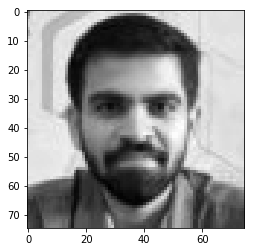

In [66]:
plt.imshow((test_img + mean).T[0].reshape(75,-1), cmap='gray')

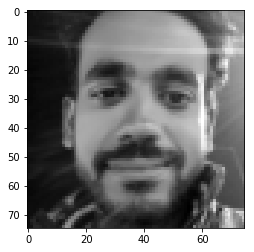

In [67]:
plt.imshow((test_img + mean).T[1].reshape(75,-1), cmap='gray')

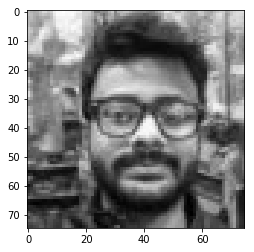

In [68]:
plt.imshow((test_img + mean).T[2].reshape(75,-1), cmap='gray')

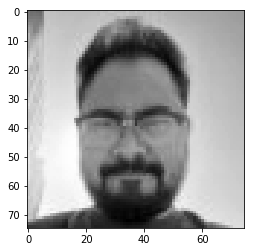

In [69]:
plt.imshow((test_img + mean).T[3].reshape(75,-1), cmap='gray')

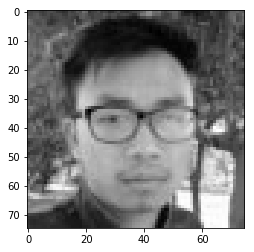

In [70]:
plt.imshow((test_img + mean).T[4].reshape(75,-1), cmap='gray')

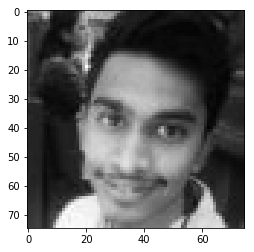

In [71]:
plt.imshow((test_img + mean).T[5].reshape(75,-1), cmap='gray')